# Text-to-Image Retrieval Benchmark

This notebook provides a demo benchmark for the text-to-image retrieval performance of a given feature extraction model by evaluating Recall@1 across varying text token limits. It performs the following steps:

1. Loads configuration from a YAML file
2. Initializes a FeatureExtractor model
3. Reads image file paths and text documents
4. Processes images to create a FAISS index for image vectors
5. Iteratively truncates text documents to different token limits, processes them into text vectors, builds corresponding FAISS indices, and computes retrieval metrics
6. Saves the numeric Recall@1 results and generates a plot comparing token limits versus Recall@1

## Required modules
- os, yaml, faiss, numpy, pandas, matplotlib
- data_processor (For processing data and computing metrics, data_processor.py)
- feature_extractor (To load and use the feature extraction model, feature_extractor.py)

In [1]:
# Import necessary libraries
import os
import yaml
import faiss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from data_processor import (
    get_ordered_paths,
    process_all_images,
    process_all_texts,
    make_faiss_index,
    get_metrics
)

from feature_extractor import FeatureExtractor

## 1. Load Configuration

Load settings from the YAML configuration file.

In [3]:
# Load configuration from config2.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

model_cfg = config["model"]
paths_cfg = config["paths"]
data_cfg = config["dataset"]
token_cfg = config["token_steps"]

# Display configuration
print("Model Configuration:")
print(model_cfg)
print("\nPaths Configuration:")
print(paths_cfg)
print("\nDataset Configuration:")
print(data_cfg)
print("\nToken Steps Configuration:")
print(token_cfg)

Model Configuration:
{'name': 'clip_base', 'checkpoint_path': '/path/to/checkpoint.pt'}

Paths Configuration:
{'csv_path': 'urban1k.csv', 'image_folder': 'Urban1k/image/', 'faiss_save_dir': 'faiss_save_dir/', 'results_dir': 'results/'}

Dataset Configuration:
{'name': 'urban1k'}

Token Steps Configuration:
{'start': 1, 'stop': 100, 'step': 10}


## 2. Initialize the Feature Extractor

Set up the model that will be used to extract features from both images and text.

In [6]:
# Initialize the FeatureExtractor with parameters from config
vectorizer = FeatureExtractor(
    model_name=model_cfg.get("name", "clip_base"),
    checkpoint=model_cfg.get("checkpoint_path") if "longclip" in model_cfg.get("name", "").lower() else None
)

print(f"Initialized feature extractor using model: {model_cfg.get('name', 'clip_base')}")

openai/clip-vit-base-patch32


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Initialized feature extractor using model: clip_base


## 3. Load File Paths & Create Output Directories

Set up paths and ensure required directories exist.

In [9]:
# Load file paths & create output directories
file_path    = paths_cfg["csv_path"]
image_folder = paths_cfg["image_folder"]
save_dir     = paths_cfg["faiss_save_dir"]
result_dir   = paths_cfg["results_dir"]

# Create directories if they do not exist
os.makedirs(save_dir, exist_ok=True)
os.makedirs(result_dir, exist_ok=True)

# Construct an output name based on model and dataset names
output_name = "recalls_vs_tokens_" + model_cfg["name"] + "_" + data_cfg["name"]

print(f"CSV path: {file_path}")
print(f"Image folder: {image_folder}")
print(f"FAISS save directory: {save_dir}")
print(f"Results directory: {result_dir}")
print(f"Output name: {output_name}")

CSV path: urban1k.csv
Image folder: Urban1k/image/
FAISS save directory: faiss_save_dir/
Results directory: results/
Output name: recalls_vs_tokens_clip_base_urban1k


## 4. Read CSV and Prepare Data

Load and prepare the image paths and text documents.

In [12]:
# Get ordered image paths using a helper function
image_paths = get_ordered_paths(image_folder, file_path)

# Load CSV containing text documents
df = pd.read_csv(file_path, dtype={'document': str})
if "document" not in df.columns:
    raise ValueError("CSV file must contain a 'document' column for text data.")
ordered_texts = df["document"].tolist()

print(f"Loaded {len(image_paths)} image paths")
print(f"Loaded {len(ordered_texts)} text documents")

# Display sample data (first entry)
if len(image_paths) > 0 and len(ordered_texts) > 0:
    print("\nSample image path:", image_paths[0])
    print("\nSample text document (truncated):", ordered_texts[0][:100], "...")

Loaded 1000 image paths
Loaded 1000 text documents

Sample image path: Urban1k/image/1.jpg

Sample text document (truncated): This image depicts a lively outdoor café scene on a sunny day. Patrons sit at tables under a large o ...


## 5. Process Images and Create Image FAISS Index

Process all images to extract feature vectors and build a FAISS index for efficient similarity search.

In [17]:
print("Processing images and creating FAISS index...")
# Process images to extract their feature vectors
image_vectors = process_all_images(image_paths, vectorizer)
# print(f"Processed {len(image_vectors)} images with vector shape: {image_vectors.shape}")

# Build a FAISS index from the image vectors for efficient similarity search
image_db = make_faiss_index(image_vectors)
print("Created FAISS index for images")

# Save the FAISS index for images
image_db_filename = os.path.join(save_dir, f"{model_cfg['name']}_image.bin")
faiss.write_index(image_db, image_db_filename)
print(f"Image FAISS index saved to: {image_db_filename}")

Processing images and creating FAISS index...
Created FAISS index for images
Image FAISS index saved to: faiss_save_dir/clip_base_image.bin


## 6. Evaluate Text-to-Image Retrieval at Different Token Limits

Iteratively evaluate the retrieval performance with varying text token limits.

In [22]:
recalls_1 = []  # To store Recall@1 values for different token limits

# Determine token limits from the configuration
token_values = range(token_cfg["start"], token_cfg["stop"], token_cfg["step"])

print("Evaluating text-to-image retrieval with varying token limits...")
for token_limit in token_values:
    print(f"\nProcessing token limit: {token_limit}")
    
    # Truncate each document to 'token_limit' tokens
    truncated_texts = [
        vectorizer.truncate_text_by_tokens(doc, token_limit) for doc in ordered_texts
    ]
    
    # Process the truncated texts to extract their feature vectors
    text_vectors = process_all_texts(truncated_texts, vectorizer)
    # print(f"Processed {len(text_vectors)} texts with vector shape: {text_vectors.shape}")
    
    # Create a FAISS index from the text vectors
    text_db = make_faiss_index(text_vectors)
    print("Created FAISS index for texts")
    
    # Optional: Save the FAISS index for the current token limit
    text_db_filename = os.path.join(save_dir, f"{model_cfg['name']}_token_{token_limit}.bin")
    faiss.write_index(text_db, text_db_filename)
    print(f"Text FAISS index saved to: {text_db_filename}")
    
    # Compute retrieval metrics
    metrics_df = get_metrics(text_db, image_db, k=1000)
    
    # Display metrics
    print("\nRetrieval metrics:")
    print(metrics_df)
    
    # Assume that the second row in the "Value" column represents Recall@1
    recall_1_value = metrics_df["Value"].iloc[1]
    recalls_1.append(recall_1_value)
    print(f"Token limit: {token_limit}, Recall@1: {recall_1_value}")

Evaluating text-to-image retrieval with varying token limits...

Processing token limit: 1
Created FAISS index for texts
Text FAISS index saved to: faiss_save_dir/clip_base_token_1.bin

Retrieval metrics:
        Metric     Value
0       MRR@10  0.002929
1     Recall@1  0.001000
2    Recall@10  0.010000
3  Recall@1000  0.100000
Token limit: 1, Recall@1: 0.001

Processing token limit: 11
Created FAISS index for texts
Text FAISS index saved to: faiss_save_dir/clip_base_token_11.bin

Retrieval metrics:
        Metric    Value
0       MRR@10  0.18049
1     Recall@1  0.12800
2    Recall@10  0.32100
3  Recall@1000  0.60400
Token limit: 11, Recall@1: 0.128

Processing token limit: 21
Created FAISS index for texts
Text FAISS index saved to: faiss_save_dir/clip_base_token_21.bin

Retrieval metrics:
        Metric     Value
0       MRR@10  0.353184
1     Recall@1  0.262000
2    Recall@10  0.573000
3  Recall@1000  0.867000
Token limit: 21, Recall@1: 0.262

Processing token limit: 31
Created FAISS

Token indices sequence length is longer than the specified maximum sequence length for this model (82 > 77). Running this sequence through the model will result in indexing errors


Created FAISS index for texts
Text FAISS index saved to: faiss_save_dir/clip_base_token_81.bin

Retrieval metrics:
        Metric     Value
0       MRR@10  0.487002
1     Recall@1  0.378000
2    Recall@10  0.723000
3  Recall@1000  0.955000
Token limit: 81, Recall@1: 0.378

Processing token limit: 91
Created FAISS index for texts
Text FAISS index saved to: faiss_save_dir/clip_base_token_91.bin

Retrieval metrics:
        Metric     Value
0       MRR@10  0.506811
1     Recall@1  0.401000
2    Recall@10  0.737000
3  Recall@1000  0.959000
Token limit: 91, Recall@1: 0.401


## 7. Save Results and Generate Plot

Save the numeric Recall@1 results and create a visualization of token limits versus retrieval performance.

In [25]:
# Save the Recall@1 results as a CSV file
recall_csv_path = os.path.join(result_dir, f"{output_name}.csv")
np.savetxt(recall_csv_path, recalls_1, delimiter=",")
print(f"Recall@1 values saved to: {recall_csv_path}")

# Create a DataFrame for better visibility in the notebook
results_df = pd.DataFrame({
    'Token Limit': list(token_values),
    'Recall@1': recalls_1
})
display(results_df)

Recall@1 values saved to: results/recalls_vs_tokens_clip_base_urban1k.csv


,Token Limit,Recall@1
0,1,0.001
1,11,0.128
2,21,0.262
3,31,0.347
4,41,0.386
5,51,0.437
6,61,0.441
7,71,0.454
8,81,0.378
9,91,0.401


Plot saved to: results/recalls_vs_tokens_clip_base_urban1k.png


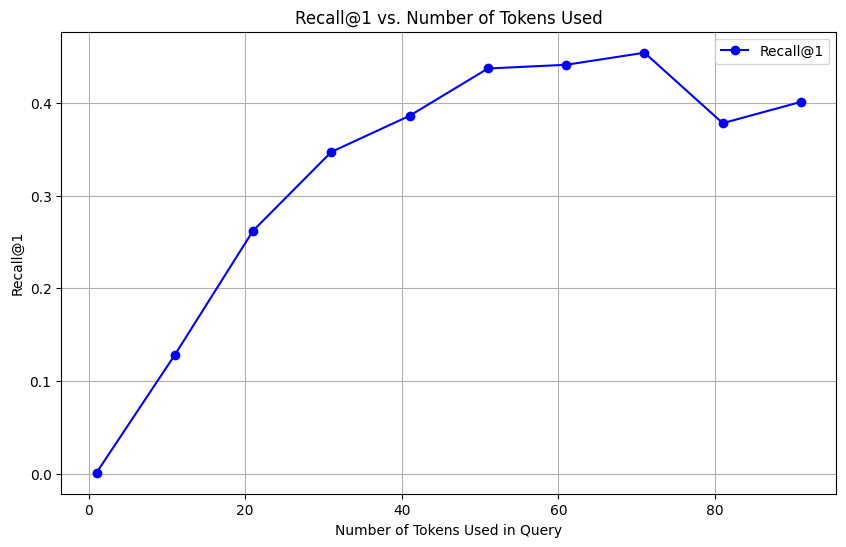

In [27]:
# Generate a plot of Recall@1 vs. Number of Tokens used in the query
plt.figure(figsize=(10, 6))
plt.plot(token_values, recalls_1, marker='o', linestyle='-', color='blue', label='Recall@1')
plt.xlabel("Number of Tokens Used in Query")
plt.ylabel("Recall@1")
plt.title("Recall@1 vs. Number of Tokens Used")
plt.legend()
plt.grid(True)

# Save the plot as a PNG file
plot_path = os.path.join(result_dir, f"{output_name}.png")
plt.savefig(plot_path)
print(f"Plot saved to: {plot_path}")

# Display the plot in the notebook
plt.show()